In [1]:
# Imports
import os
import random
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import models
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR


In [2]:
# Step 1: Mount Google Drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/cataract_models/dataset_V4.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V4"

# Step 3: Unzip the dataset
import zipfile

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")




# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/cataract_models/dataset_V4.csv"
csv_colab_path = "/content/dataset_V4.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")




✅ Extracted dataset to: /content/dataset_V4
✅ CSV copied to: /content/dataset_V4.csv


In [4]:
class PadToSquareWithMean:
    def __call__(self, image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left = (max_dim - w) // 2
        pad_top = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom = max_dim - h - pad_top

        # Compute true mean color
        np_img = np.array(image)
        mean_color = tuple(np_img.reshape(-1, 3).mean(axis=0).astype(np.uint8))

        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')


In [25]:
CSV_PATH = "dataset_V4.csv"
IMAGE_DIR = "/content/dataset_V4/dataset_V4"

# ===== Base + Augmentation Transforms =====
base_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # standard ImageNet normalization
])

aug_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((300, 300)),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(15, translate=(0.1,0.1)),
    # transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]


In [6]:
def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
    """
    EfficientNet-B2 with progressive fine-tuning.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool
        Whether to load ImageNet pretrained weights.
    phase : str
        "warmup"   → train only classifier
        "partial"  → unfreeze last 2 feature blocks + classifier
        "full"     → train all layers

    Returns
    -------
    model : nn.Module
    """
    weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b2(weights=weights)

    # Replace final classifier
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)

    # Set requires_grad depending on phase
    for name, param in model.named_parameters():
        param.requires_grad = False  # freeze everything first

        if phase == "warmup" and name.startswith("classifier"):
            param.requires_grad = True

        elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
            param.requires_grad = True

        elif phase == "full":
            param.requires_grad = True

    return model


In [7]:
def efficientnet_b3(num_classes=5, pretrained=True, phase="warmup"):
    """
    EfficientNet-B3 with progressive fine-tuning.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool
        Whether to load ImageNet pretrained weights.
    phase : str
        "warmup"   → train only classifier
        "partial"  → unfreeze last 2 feature blocks + classifier
        "full"     → train all layers

    Returns
    -------
    model : nn.Module
    """
    weights = models.EfficientNet_B3_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b3(weights=weights)

    # Replace final classifier
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)

    # Freeze all parameters initially
    for name, param in model.named_parameters():
        param.requires_grad = False

        if phase == "warmup" and name.startswith("classifier"):
            param.requires_grad = True

        # EfficientNet-B3 has 8 feature blocks (features.0 through features.8)
        elif phase == "partial" and name.startswith(("features.7", "features.8", "classifier")):
            param.requires_grad = True

        elif phase == "full":
            param.requires_grad = True

    return model


In [ ]:
class EfficientNetB2WithDropout(nn.Module):
    def __init__(self, num_classes=5, drop_p=0.2, phase="warmup"):
        super().__init__()
        # load pretrained B2 backbone
        weights = models.EfficientNet_B2_Weights.DEFAULT
        self.net = models.efficientnet_b2(weights=weights)

        # replace classifier head with Dropout + Linear
        in_feats = self.net.classifier[1].in_features
        self.net.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_feats, num_classes)
        )

        # then set requires_grad per your phase…
        for name, param in self.net.named_parameters():
            param.requires_grad = False
            if phase == "warmup" and name.startswith("classifier"):
                param.requires_grad = True
            elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
                param.requires_grad = True
            elif phase == "full":
                param.requires_grad = True

    def forward(self, x):
        return self.net(x)


In [8]:
# ========= Balance Function =========
def balance_dataset(df, image_dir, target_per_class = df['label'].value_counts().max()):
    datasets = []
    class_counts = df['label'].value_counts().to_dict()
    augmented_summary = {}

    for label, count in class_counts.items():
        class_df = df[df['label'] == label]

        # Keep all original samples
        datasets.append(CataractDataset(class_df, image_dir, transform=base_transform))

        # Only add augmentation if class is below target
        if count < target_per_class:
            needed = target_per_class - count
            aug_rows = class_df.sample(needed, replace=True, random_state=42)
            datasets.append(CataractDataset(aug_rows, image_dir, transform=aug_transform))
            augmented_summary[label] = needed
        else:
            augmented_summary[label] = 0  # nothing added

    balanced_dataset = ConcatDataset(datasets)

    # Print summary
    print("\n=== Balancing Summary (No Downsampling) ===")
    for label, count in class_counts.items():
        added = augmented_summary[label]
        final_count = count + added
        print(f"{label:15s} | Original: {count:4d} | Added: {added:4d} | Final: {final_count:4d}")
    print(f"\nTotal balanced dataset size: {len(balanced_dataset)}")

    return balanced_dataset


df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive labels from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"

df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========= Split Dataset =========
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ========= Create Datasets =========
train_dataset = balance_dataset(train_df, IMAGE_DIR, target_per_class=df['label'].value_counts().max())
val_dataset = CataractDataset(val_df, IMAGE_DIR, transform=base_transform)
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=base_transform)

# ========= Create DataLoaders =========
BATCH_SIZE = 64
num_cpu = multiprocessing.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cpu//2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)



Train: 1321, Val: 283, Test: 284

=== Balancing Summary (No Downsampling) ===
mature          | Original:  365 | Added:  157 | Final:  522
low             | Original:  322 | Added:  200 | Final:  522
moderate        | Original:  256 | Added:  266 | Final:  522
high            | Original:  239 | Added:  283 | Final:  522
poor dilation   | Original:  139 | Added:  383 | Final:  522

Total balanced dataset size: 2610


In [ ]:
# # Define label map globally
# LABEL_MAP = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}
# INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# # Saving augmented dataset
# import os
# from tqdm import tqdm

# save_dir = "/content/balanced_train_images"
# os.makedirs(save_dir, exist_ok=True)

# balanced_records = []

# for i, (image, label) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
#     label_name = INV_LABEL_MAP[label.item()]
#     label_dir = os.path.join(save_dir, label_name.replace(" ", "_"))
#     os.makedirs(label_dir, exist_ok=True)
#     img_path = os.path.join(label_dir, f"img_{i}.jpg")

#     # Convert tensor to PIL before saving
#     img_pil = transforms.ToPILImage()(image)
#     img_pil.save(img_path)

#     balanced_records.append({"filename": f"{label_name.replace(' ', '_')}/img_{i}.jpg",
#                              "label": label_name})

# # Save CSV pointing to augmented images
# balanced_df = pd.DataFrame(balanced_records)
# csv_path = "/content/balanced_train.csv"
# balanced_df.to_csv(csv_path, index=False)

# print(f"Balanced dataset saved: {len(balanced_df)} samples")
# print(f"Images directory: {save_dir}")
# print(f"CSV path: {csv_path}")


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== EfficientNet with Progressive Phases =====
# def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
#     weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
#     model = models.efficientnet_b2(weights=weights)

#     # Replace classifier
#     in_feats = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_feats, num_classes)

#     # Freeze/unfreeze according to phase
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#         if phase == "warmup" and name.startswith("classifier"):
#             param.requires_grad = True
#         elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
#             param.requires_grad = True
#         elif phase == "full":
#             param.requires_grad = True

#     return model

# ===== Training Utilities =====
def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs, phase_name):
    model.train()
    running_loss, preds_all, labels_all = 0.0, [], []
    total_steps = len(loader)

    for step, (images, labels) in enumerate(loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

        # Print per-step loss
        if (step+1) % 5 == 0:
          print(f"[{phase_name} | Epoch {epoch}/{total_epochs} | Step {step}/{total_steps}] "
              f"Step Loss: {loss.item():.4f}")


    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, preds_all, labels_all, probs_all = 0.0, [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            probs_all.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all, probs_all


def progressive_training(train_loader, val_loader, num_classes=5):
    phases = [
        {"name": "warmup", "epochs": 10, "lr": 1e-3},
        {"name": "partial", "epochs": 15, "lr": 5e-5},
        {"name": "full", "epochs": 20, "lr": 5e-6},
    ]

    criterion = nn.CrossEntropyLoss()
    prev_phase = None

    all_train_losses = []
    all_val_losses = []

    for phase in phases:
        print(f"\n=== Phase: {phase['name']} ===")

        if prev_phase is None:
            # model = efficientnet_b2(num_classes=num_classes, phase="warmup").to(device)
            model = efficientnet_b3(num_classes=num_classes, phase="warmup").to(device)
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase="warmup").to(device)

        else:
            # model = efficientnet_b2(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            model = efficientnet_b3(num_classes=num_classes, phase=phase["name"]).to(device)
            model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
        #                        lr=phase["lr"], weight_decay=1e-4)

        optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=phase["lr"],              # keep the LR from your phase config
        weight_decay=1e-4            # same weight decay you used before
        )

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        # # T_max is the number of epochs over which to anneal from initial lr → eta_min
        # scheduler = CosineAnnealingLR(
        #     optimizer,
        #     T_max=phase["epochs"],
        #     eta_min=1e-6,    # floor learning rate
        #     last_epoch=-1    # start from scratch each phase
        # )

        best_val_loss = np.inf
        patience, patience_counter = 3, 0

        for epoch in range(1, phase["epochs"] + 1):
            train_loss, train_acc, train_f1, y_train, y_pred_train = train_one_epoch(
                model, train_loader, optimizer, criterion, epoch, phase["epochs"], phase["name"])
            val_loss, val_acc, val_f1, y_val, y_pred_val, y_proba_val = evaluate(
                model, val_loader, criterion)

            # # update LR scheduler
            # if isinstance(scheduler, ReduceLROnPlateau):
            #     scheduler.step(val_loss)
            # else:
            #     scheduler.step()

            # scheduler.step()

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # End of epoch summary
            print(f"Epoch [{epoch}/{phase['epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_{phase['name']}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # ---- After each phase: Per-class metrics ----
        print(f"\n=== Detailed Metrics for Phase: {phase['name']} ===")
        print(classification_report(y_val, y_pred_val, target_names=["low", "moderate", "high", "mature", "poor dilation"]))

        cm = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["low", "moderate", "high", "mature", "poor dilation"])
        disp.plot(cmap="Blues")
        plt.show()

        # ROC-AUC (One-vs-Rest)
        try:
            roc_auc = roc_auc_score(y_val, y_proba_val, multi_class="ovr")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (need probabilities for all classes).")

        prev_phase = phase["name"]


    plt.figure(figsize=(8,6))
    plt.plot(all_train_losses, label="Train Loss")
    plt.plot(all_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nTraining complete. Best models for each phase saved.")
    return model


**EFFICIENTNET B2 WITH DROPOUT**


=== Phase: warmup ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/10 | Step 4/41] Step Loss: 1.5894
[warmup | Epoch 1/10 | Step 9/41] Step Loss: 1.5290
[warmup | Epoch 1/10 | Step 14/41] Step Loss: 1.5384
[warmup | Epoch 1/10 | Step 19/41] Step Loss: 1.5335
[warmup | Epoch 1/10 | Step 24/41] Step Loss: 1.5090
[warmup | Epoch 1/10 | Step 29/41] Step Loss: 1.3722
[warmup | Epoch 1/10 | Step 34/41] Step Loss: 1.3720
[warmup | Epoch 1/10 | Step 39/41] Step Loss: 1.3607
Epoch [1/10], Train Loss: 1.4488, Acc: 0.3958, F1: 0.3941 | Val Loss: 1.3064, Acc: 0.5336, F1: 0.4840
[warmup | Epoch 2/10 | Step 4/41] Step Loss: 1.4394
[warmup | Epoch 2/10 | Step 9/41] Step Loss: 1.2975
[warmup | Epoch 2/10 | Step 14/41] Step Loss: 1.2683
[warmup | Epoch 2/10 | Step 19/41] Step Loss: 1.1414
[warmup | Epoch 2/10 | Step 24/41] Step Loss: 1.1590
[warmup | Epoch 2/10 | Step 29/41] Step Loss: 1.1662
[warmup | Epoch 2/10 | Step 34/41] Step Loss: 1.1806
[warmup | Epoch 2/10 | Step 39/41] Step Loss: 1.0921
Epoch [2/10], Train Loss: 1.2205, Acc: 0.5414, F1: 0.5

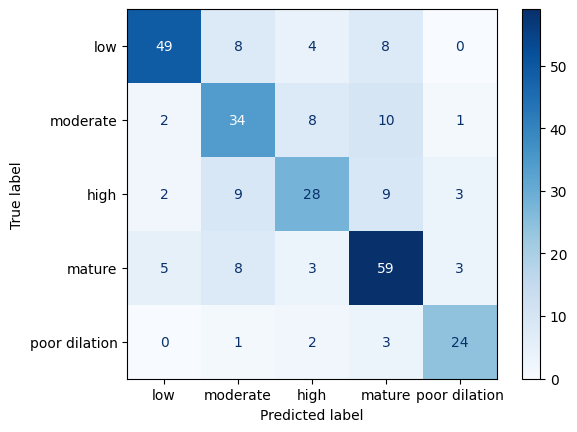

ROC-AUC: 0.8914

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[partial | Epoch 1/15 | Step 4/41] Step Loss: 0.7155
[partial | Epoch 1/15 | Step 9/41] Step Loss: 0.6102
[partial | Epoch 1/15 | Step 14/41] Step Loss: 0.4693
[partial | Epoch 1/15 | Step 19/41] Step Loss: 0.5270
[partial | Epoch 1/15 | Step 24/41] Step Loss: 0.5518
[partial | Epoch 1/15 | Step 29/41] Step Loss: 0.5275
[partial | Epoch 1/15 | Step 34/41] Step Loss: 0.3529
[partial | Epoch 1/15 | Step 39/41] Step Loss: 0.4752
Epoch [1/15], Train Loss: 0.5363, Acc: 0.7916, F1: 0.7914 | Val Loss: 0.5858, Acc: 0.7915, F1: 0.7865
[partial | Epoch 2/15 | Step 4/41] Step Loss: 0.3186
[partial | Epoch 2/15 | Step 9/41] Step Loss: 0.2310
[partial | Epoch 2/15 | Step 14/41] Step Loss: 0.2121
[partial | Epoch 2/15 | Step 19/41] Step Loss: 0.2009
[partial | Epoch 2/15 | Step 24/41] Step Loss: 0.2163
[partial | Epoch 2/15 | Step 29/41] Step Loss: 0.2328
[partial | Epoch 2/15 | Step 34/41] Step Loss: 0.1462
[partial | Epoch 2/15 | Step 39/41] Step Loss: 0.1190
Epoch [2/15], Train Loss: 0.1710, Acc:

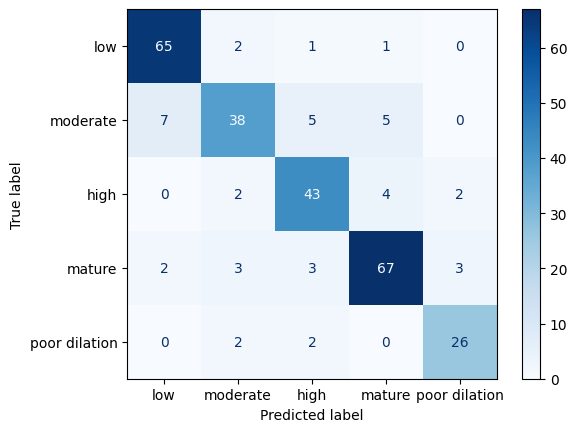

ROC-AUC: 0.9749

=== Phase: full ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[full | Epoch 1/20 | Step 4/41] Step Loss: 0.1038
[full | Epoch 1/20 | Step 9/41] Step Loss: 0.0658
[full | Epoch 1/20 | Step 14/41] Step Loss: 0.2357
[full | Epoch 1/20 | Step 19/41] Step Loss: 0.0585
[full | Epoch 1/20 | Step 24/41] Step Loss: 0.0341
[full | Epoch 1/20 | Step 29/41] Step Loss: 0.0644
[full | Epoch 1/20 | Step 34/41] Step Loss: 0.1535
[full | Epoch 1/20 | Step 39/41] Step Loss: 0.0507
Epoch [1/20], Train Loss: 0.0864, Acc: 0.9739, F1: 0.9740 | Val Loss: 0.4770, Acc: 0.8657, F1: 0.8648
[full | Epoch 2/20 | Step 4/41] Step Loss: 0.1520
[full | Epoch 2/20 | Step 9/41] Step Loss: 0.0732
[full | Epoch 2/20 | Step 14/41] Step Loss: 0.0727
[full | Epoch 2/20 | Step 19/41] Step Loss: 0.0412
[full | Epoch 2/20 | Step 24/41] Step Loss: 0.1009
[full | Epoch 2/20 | Step 29/41] Step Loss: 0.0908
[full | Epoch 2/20 | Step 34/41] Step Loss: 0.0296
[full | Epoch 2/20 | Step 39/41] Step Loss: 0.1659
Epoch [2/20], Train Loss: 0.0708, Acc: 0.9843, F1: 0.9843 | Val Loss: 0.4813, Acc: 0.8

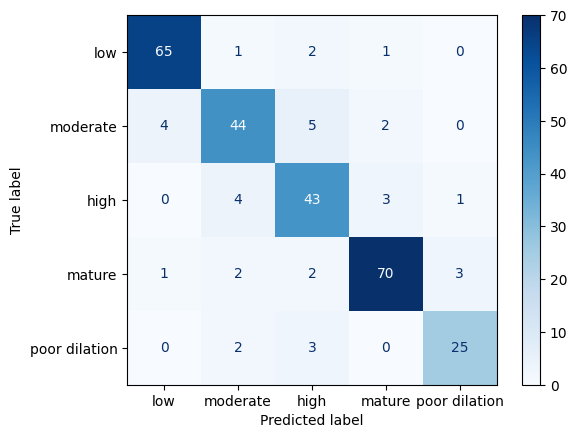

ROC-AUC: 0.9750


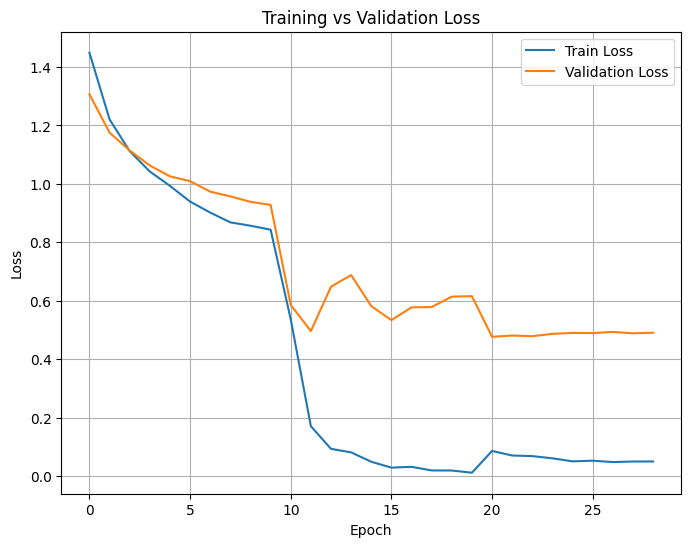


Training complete. Best models for each phase saved.


In [ ]:
model = progressive_training(train_loader, val_loader, num_classes=5)

**EFFCIENTNET B3 TRAINING**


=== Phase: warmup ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/10 | Step 4/41] Step Loss: 1.5890
[warmup | Epoch 1/10 | Step 9/41] Step Loss: 1.5347
[warmup | Epoch 1/10 | Step 14/41] Step Loss: 1.4847
[warmup | Epoch 1/10 | Step 19/41] Step Loss: 1.4875
[warmup | Epoch 1/10 | Step 24/41] Step Loss: 1.3455
[warmup | Epoch 1/10 | Step 29/41] Step Loss: 1.3934
[warmup | Epoch 1/10 | Step 34/41] Step Loss: 1.3427
[warmup | Epoch 1/10 | Step 39/41] Step Loss: 1.3247
Epoch [1/10], Train Loss: 1.4622, Acc: 0.3927, F1: 0.3844 | Val Loss: 1.3586, Acc: 0.4841, F1: 0.4624
[warmup | Epoch 2/10 | Step 4/41] Step Loss: 1.2881
[warmup | Epoch 2/10 | Step 9/41] Step Loss: 1.2281
[warmup | Epoch 2/10 | Step 14/41] Step Loss: 1.3548
[warmup | Epoch 2/10 | Step 19/41] Step Loss: 1.2703
[warmup | Epoch 2/10 | Step 24/41] Step Loss: 1.2868
[warmup | Epoch 2/10 | Step 29/41] Step Loss: 1.2564
[warmup | Epoch 2/10 | Step 34/41] Step Loss: 1.2388
[warmup | Epoch 2/10 | Step 39/41] Step Loss: 1.2421
Epoch [2/10], Train Loss: 1.2709, Acc: 0.5199, F1: 0.5

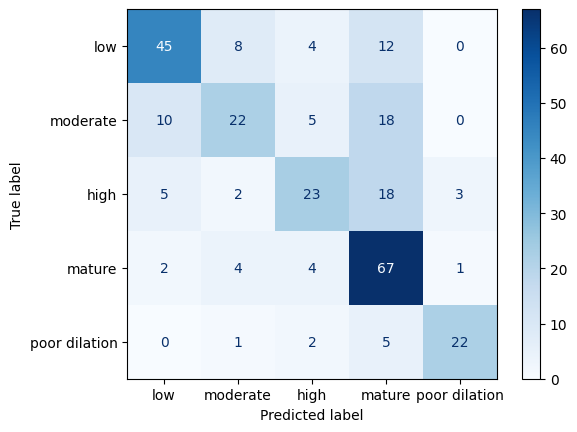

ROC-AUC: 0.8744

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[partial | Epoch 1/15 | Step 4/41] Step Loss: 0.7549
[partial | Epoch 1/15 | Step 9/41] Step Loss: 0.8621
[partial | Epoch 1/15 | Step 14/41] Step Loss: 0.7818
[partial | Epoch 1/15 | Step 19/41] Step Loss: 0.7899
[partial | Epoch 1/15 | Step 24/41] Step Loss: 0.9959
[partial | Epoch 1/15 | Step 29/41] Step Loss: 0.8274
[partial | Epoch 1/15 | Step 34/41] Step Loss: 0.8512
[partial | Epoch 1/15 | Step 39/41] Step Loss: 0.8113
Epoch [1/15], Train Loss: 0.8660, Acc: 0.6747, F1: 0.6715 | Val Loss: 0.9042, Acc: 0.6678, F1: 0.6682
[partial | Epoch 2/15 | Step 4/41] Step Loss: 0.7490
[partial | Epoch 2/15 | Step 9/41] Step Loss: 0.8470
[partial | Epoch 2/15 | Step 14/41] Step Loss: 0.6663
[partial | Epoch 2/15 | Step 19/41] Step Loss: 0.7121
[partial | Epoch 2/15 | Step 24/41] Step Loss: 0.7908
[partial | Epoch 2/15 | Step 29/41] Step Loss: 0.7024
[partial | Epoch 2/15 | Step 34/41] Step Loss: 0.7876
[partial | Epoch 2/15 | Step 39/41] Step Loss: 0.6882
Epoch [2/15], Train Loss: 0.7678, Acc:

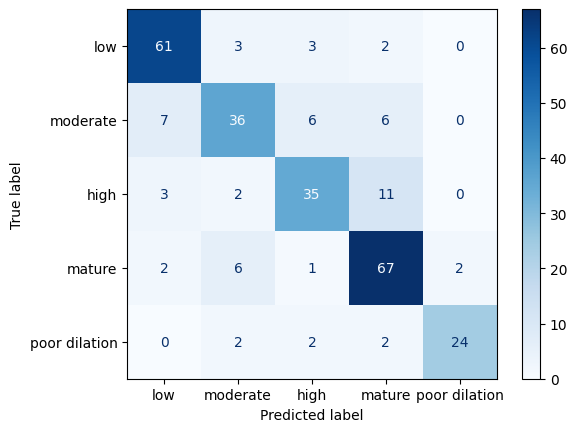

ROC-AUC: 0.9505

=== Phase: full ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[full | Epoch 1/20 | Step 4/41] Step Loss: 0.3140
[full | Epoch 1/20 | Step 9/41] Step Loss: 0.2507
[full | Epoch 1/20 | Step 14/41] Step Loss: 0.2835
[full | Epoch 1/20 | Step 19/41] Step Loss: 0.2975
[full | Epoch 1/20 | Step 24/41] Step Loss: 0.3542
[full | Epoch 1/20 | Step 29/41] Step Loss: 0.2342
[full | Epoch 1/20 | Step 34/41] Step Loss: 0.2712
[full | Epoch 1/20 | Step 39/41] Step Loss: 0.2236
Epoch [1/20], Train Loss: 0.2870, Acc: 0.9050, F1: 0.9049 | Val Loss: 0.6182, Acc: 0.7915, F1: 0.7895
[full | Epoch 2/20 | Step 4/41] Step Loss: 0.2554
[full | Epoch 2/20 | Step 9/41] Step Loss: 0.2420
[full | Epoch 2/20 | Step 14/41] Step Loss: 0.2098
[full | Epoch 2/20 | Step 19/41] Step Loss: 0.2839
[full | Epoch 2/20 | Step 24/41] Step Loss: 0.3007
[full | Epoch 2/20 | Step 29/41] Step Loss: 0.2920
[full | Epoch 2/20 | Step 34/41] Step Loss: 0.2533
[full | Epoch 2/20 | Step 39/41] Step Loss: 0.2747
Epoch [2/20], Train Loss: 0.2721, Acc: 0.9142, F1: 0.9141 | Val Loss: 0.6085, Acc: 0.7

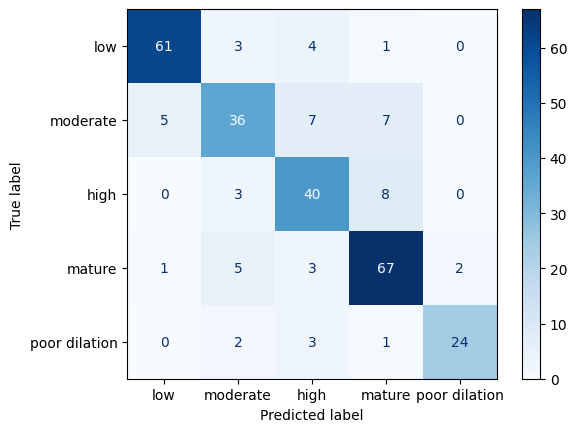

ROC-AUC: 0.9666


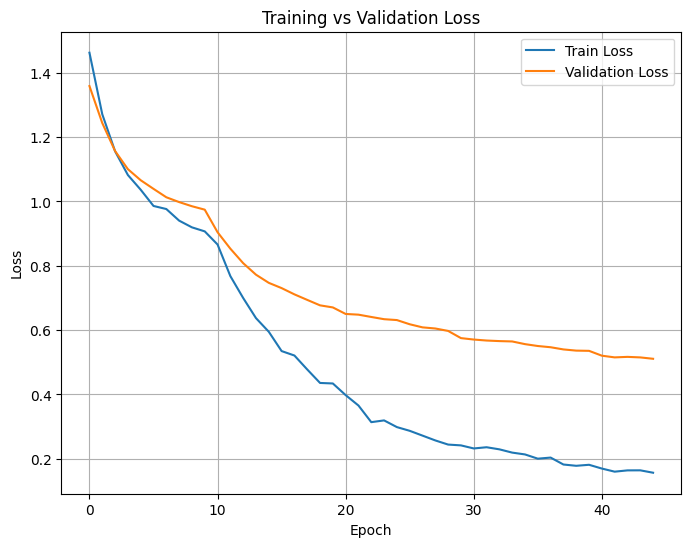


Training complete. Best models for each phase saved.


In [27]:
# Run the progressive training
model = progressive_training(train_loader, val_loader, num_classes=5)

**EFFICIENTNET B3 TEST DATASET RESULTS**

Classification Report on Test Set:
               precision    recall  f1-score   support

          low       0.91      0.87      0.89        69
     moderate       0.75      0.78      0.77        55
         high       0.72      0.75      0.73        51
       mature       0.87      0.82      0.84        79
poor dilation       0.85      0.93      0.89        30

     accuracy                           0.82       284
    macro avg       0.82      0.83      0.82       284
 weighted avg       0.83      0.82      0.82       284

Confusion Matrix:
[[60  5  3  1  0]
 [ 4 43  5  3  0]
 [ 1  5 38  5  2]
 [ 1  4  6 65  3]
 [ 0  0  1  1 28]]


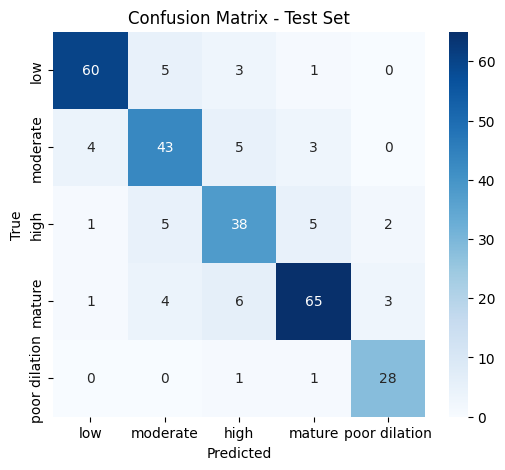

In [28]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define label map (must match training dataset)
label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

model.eval()  # Set model to evaluation mode
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

# Classification report
print("Classification Report on Test Set:")
print(classification_report(test_labels, test_preds, target_names=list(label_map.keys())))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


Embeddings shape: (1321, 1536)  | Labels: (1321,)


/tmp/ipython-input-3840853860.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10', num_classes)


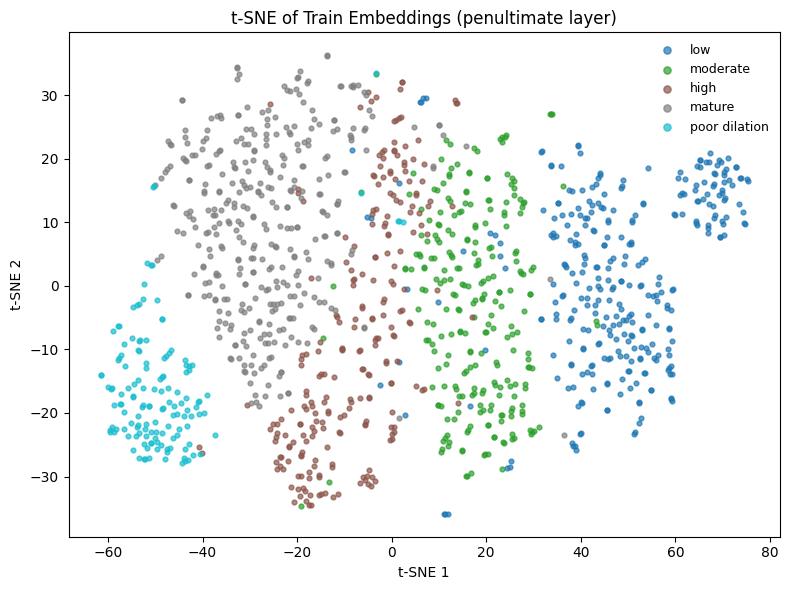

In [29]:
# --- 0) No-aug train loader for feature extraction ---
# Use the same base_transform you already use for val/test
feat_dataset = CataractDataset(train_df.reset_index(drop=True), IMAGE_DIR, transform=base_transform)
feat_loader  = DataLoader(feat_dataset, batch_size=64, shuffle=False,
                          num_workers=num_cpu//2, pin_memory=True)

# If you need label names in a fixed order:
classes = ["low", "moderate", "high", "mature", "poor dilation"]
name_to_idx = {c:i for i,c in enumerate(classes)}

# --- 1) Collect penultimate-layer embeddings with a hook ---
import torch
import numpy as np

model.eval()
emb_chunks, lab_chunks = [], []

# For torchvision/timm EfficientNet, the classifier is in model.classifier (Sequential[Dropout, Linear]).
# A forward *pre*-hook on `classifier` gives the tensor right before the head = penultimate embedding.
def _feat_hook(module, inputs):
    # inputs is a tuple; take the tensor [B, D]
    x = inputs[0].detach().cpu()
    emb_chunks.append(x)

hook_handle = model.classifier.register_forward_pre_hook(lambda m, inp: _feat_hook(m, inp))

with torch.no_grad():
    for imgs, lbls in feat_loader:
        imgs = imgs.to(device)
        _ = model(imgs)                      # forward pass triggers the hook
        lab_chunks.append(lbls.cpu())

# Clean up the hook
hook_handle.remove()

embeddings = torch.cat(emb_chunks, dim=0).numpy()       # [N, D]
labels     = torch.cat(lab_chunks, dim=0).numpy()       # [N]

print("Embeddings shape:", embeddings.shape, " | Labels:", labels.shape)

# --- 2) t-SNE (PCA -> t-SNE is faster/stabler) ---
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_pca  = PCA(n_components=min(50, embeddings.shape[1]-1), random_state=42).fit_transform(embeddings)
tsne   = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
X_2d   = tsne.fit_transform(X_pca)                       # [N, 2]

# --- 3) Plot ---
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(8,6))
num_classes = len(classes)
cmap = matplotlib.cm.get_cmap('tab10', num_classes)
for idx, cls in enumerate(classes):
    mask = (labels == idx)
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=12, alpha=0.7, label=cls, color=cmap(idx))

plt.title("t-SNE of Train Embeddings (penultimate layer)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(markerscale=1.5, fontsize=9, frameon=False)
plt.tight_layout()
plt.show()

# (Optional) Save for later analysis
import pandas as pd
tsne_df = pd.DataFrame({"x": X_2d[:,0], "y": X_2d[:,1], "label": [classes[i] for i in labels]})
tsne_df.to_csv("tsne_train_embeddings.csv", index=False)


**TRAINING EFFICIENTNET B2**


=== Phase: warmup ===


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 102MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/10 | Step 4/41] Step Loss: 1.6103
[warmup | Epoch 1/10 | Step 9/41] Step Loss: 1.4913
[warmup | Epoch 1/10 | Step 14/41] Step Loss: 1.4269
[warmup | Epoch 1/10 | Step 19/41] Step Loss: 1.4294
[warmup | Epoch 1/10 | Step 24/41] Step Loss: 1.4338
[warmup | Epoch 1/10 | Step 29/41] Step Loss: 1.3576
[warmup | Epoch 1/10 | Step 34/41] Step Loss: 1.3324
[warmup | Epoch 1/10 | Step 39/41] Step Loss: 1.3573
Epoch [1/10], Train Loss: 1.4411, Acc: 0.4184, F1: 0.4125 | Val Loss: 1.3053, Acc: 0.4664, F1: 0.4227
[warmup | Epoch 2/10 | Step 4/41] Step Loss: 1.2631
[warmup | Epoch 2/10 | Step 9/41] Step Loss: 1.2106
[warmup | Epoch 2/10 | Step 14/41] Step Loss: 1.1404
[warmup | Epoch 2/10 | Step 19/41] Step Loss: 1.2270
[warmup | Epoch 2/10 | Step 24/41] Step Loss: 1.2614
[warmup | Epoch 2/10 | Step 29/41] Step Loss: 1.1255
[warmup | Epoch 2/10 | Step 34/41] Step Loss: 1.2444
[warmup | Epoch 2/10 | Step 39/41] Step Loss: 1.2230
Epoch [2/10], Train Loss: 1.1916, Acc: 0.5621, F1: 0.5

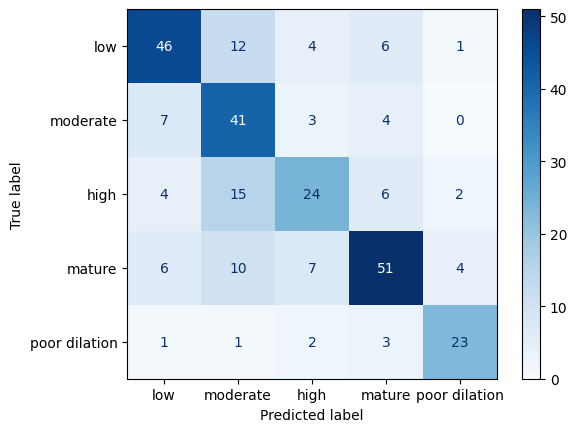

ROC-AUC: 0.8950

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[partial | Epoch 1/15 | Step 4/41] Step Loss: 0.8126
[partial | Epoch 1/15 | Step 9/41] Step Loss: 0.8845
[partial | Epoch 1/15 | Step 14/41] Step Loss: 0.8090
[partial | Epoch 1/15 | Step 19/41] Step Loss: 0.7253
[partial | Epoch 1/15 | Step 24/41] Step Loss: 0.7038
[partial | Epoch 1/15 | Step 29/41] Step Loss: 0.7120
[partial | Epoch 1/15 | Step 34/41] Step Loss: 0.5230
[partial | Epoch 1/15 | Step 39/41] Step Loss: 0.8424
Epoch [1/15], Train Loss: 0.7197, Acc: 0.7490, F1: 0.7475 | Val Loss: 0.7198, Acc: 0.7456, F1: 0.7473
[partial | Epoch 2/15 | Step 4/41] Step Loss: 0.5251
[partial | Epoch 2/15 | Step 9/41] Step Loss: 0.5200
[partial | Epoch 2/15 | Step 14/41] Step Loss: 0.5484
[partial | Epoch 2/15 | Step 19/41] Step Loss: 0.4182
[partial | Epoch 2/15 | Step 24/41] Step Loss: 0.4559
[partial | Epoch 2/15 | Step 29/41] Step Loss: 0.4694
[partial | Epoch 2/15 | Step 34/41] Step Loss: 0.4835
[partial | Epoch 2/15 | Step 39/41] Step Loss: 0.6045
Epoch [2/15], Train Loss: 0.5114, Acc:

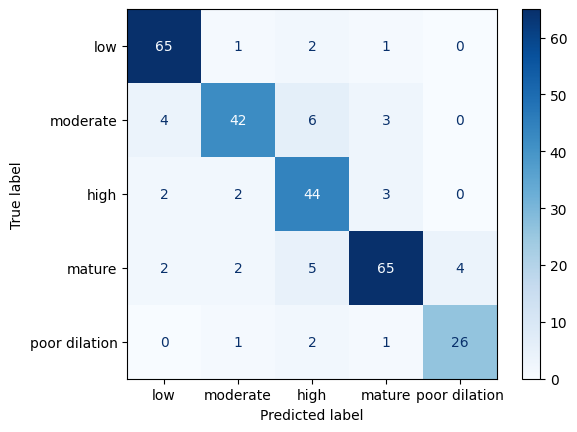

ROC-AUC: 0.9708

=== Phase: full ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[full | Epoch 1/20 | Step 4/41] Step Loss: 0.1899
[full | Epoch 1/20 | Step 9/41] Step Loss: 0.1868
[full | Epoch 1/20 | Step 14/41] Step Loss: 0.1812
[full | Epoch 1/20 | Step 19/41] Step Loss: 0.1333
[full | Epoch 1/20 | Step 24/41] Step Loss: 0.1602
[full | Epoch 1/20 | Step 29/41] Step Loss: 0.1470
[full | Epoch 1/20 | Step 34/41] Step Loss: 0.1741
[full | Epoch 1/20 | Step 39/41] Step Loss: 0.0969
Epoch [1/20], Train Loss: 0.1553, Acc: 0.9590, F1: 0.9590 | Val Loss: 0.5011, Acc: 0.8375, F1: 0.8375
[full | Epoch 2/20 | Step 4/41] Step Loss: 0.1277
[full | Epoch 2/20 | Step 9/41] Step Loss: 0.1179
[full | Epoch 2/20 | Step 14/41] Step Loss: 0.0626
[full | Epoch 2/20 | Step 19/41] Step Loss: 0.0891
[full | Epoch 2/20 | Step 24/41] Step Loss: 0.2227
[full | Epoch 2/20 | Step 29/41] Step Loss: 0.1142
[full | Epoch 2/20 | Step 34/41] Step Loss: 0.0668
[full | Epoch 2/20 | Step 39/41] Step Loss: 0.2015
Epoch [2/20], Train Loss: 0.1497, Acc: 0.9644, F1: 0.9644 | Val Loss: 0.5003, Acc: 0.8

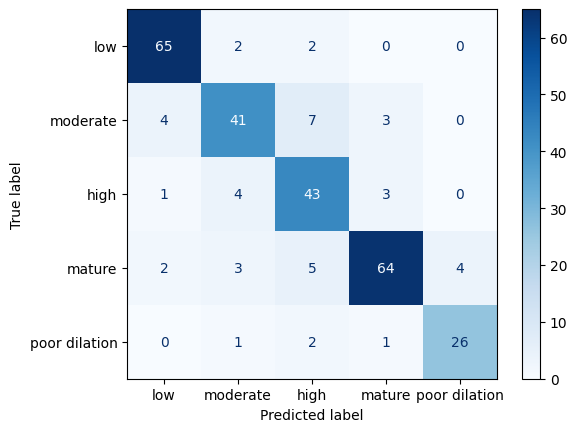

ROC-AUC: 0.9711


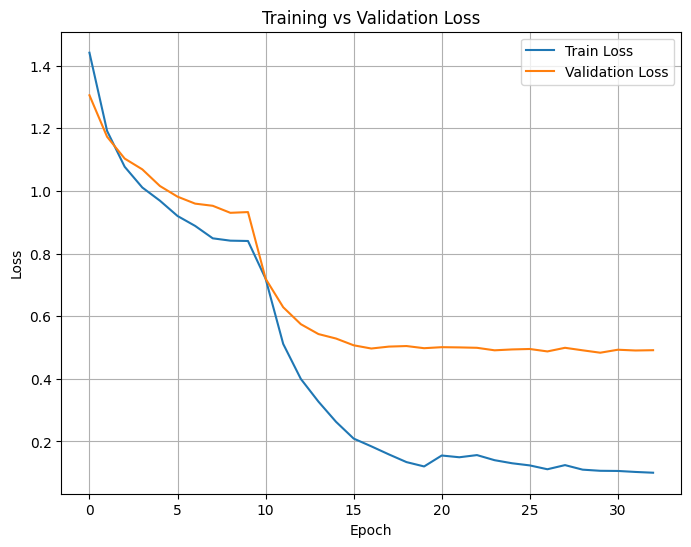


Training complete. Best models for each phase saved.


In [20]:
# Run the progressive training
model = progressive_training(train_loader, val_loader, num_classes=5)

**EFFICIENTNET B2 TEST DATASET RESULTS**

Classification Report on Test Set:
               precision    recall  f1-score   support

          low       0.91      0.88      0.90        69
     moderate       0.77      0.87      0.82        55
         high       0.86      0.75      0.80        51
       mature       0.90      0.91      0.91        79
poor dilation       0.90      0.93      0.92        30

     accuracy                           0.87       284
    macro avg       0.87      0.87      0.87       284
 weighted avg       0.87      0.87      0.87       284



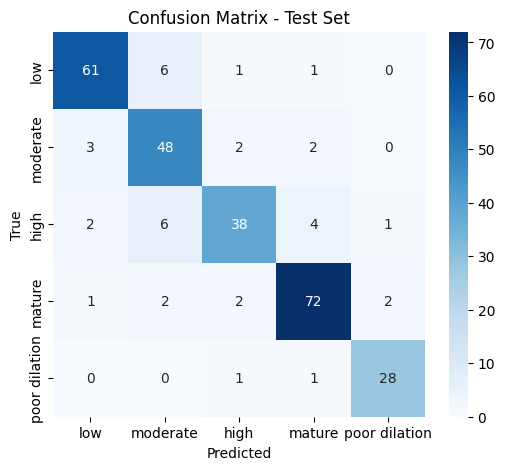

In [23]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# (Re-)define your label names:
inv_label_map = ["low", "moderate", "high", "mature", "poor dilation"]

model = efficientnet_b2(num_classes=5, phase="full").to(device)
model.load_state_dict(torch.load("best_model_full.pth"))
model.eval()

test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

print("Classification Report on Test Set:")
print(classification_report(
    test_labels,
    test_preds,
    target_names=inv_label_map
))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=inv_label_map,
            yticklabels=inv_label_map)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


Embeddings shape: (1321, 1408)  | Labels: (1321,)


/tmp/ipython-input-3840853860.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('tab10', num_classes)


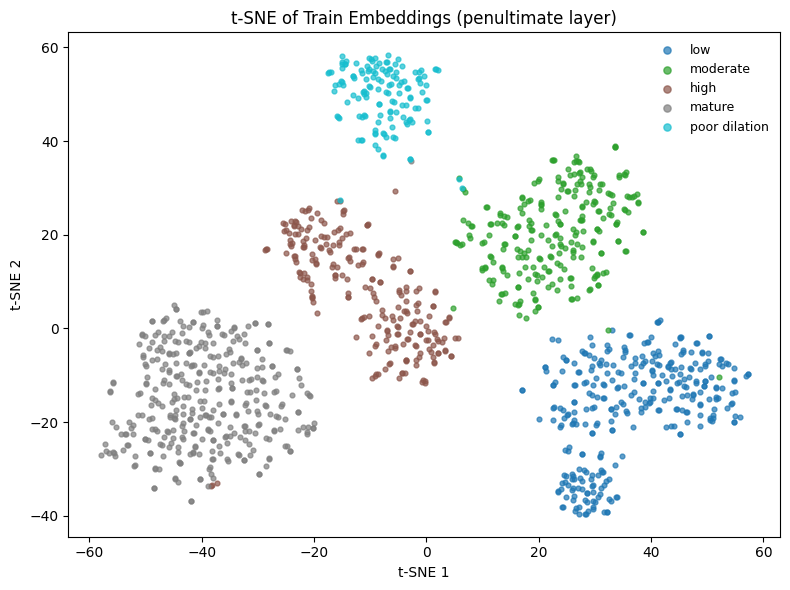

In [24]:
# --- 0) No-aug train loader for feature extraction ---
# Use the same base_transform you already use for val/test
feat_dataset = CataractDataset(train_df.reset_index(drop=True), IMAGE_DIR, transform=base_transform)
feat_loader  = DataLoader(feat_dataset, batch_size=64, shuffle=False,
                          num_workers=num_cpu//2, pin_memory=True)

# If you need label names in a fixed order:
classes = ["low", "moderate", "high", "mature", "poor dilation"]
name_to_idx = {c:i for i,c in enumerate(classes)}

# --- 1) Collect penultimate-layer embeddings with a hook ---
import torch
import numpy as np

model.eval()
emb_chunks, lab_chunks = [], []

# For torchvision/timm EfficientNet, the classifier is in model.classifier (Sequential[Dropout, Linear]).
# A forward *pre*-hook on `classifier` gives the tensor right before the head = penultimate embedding.
def _feat_hook(module, inputs):
    # inputs is a tuple; take the tensor [B, D]
    x = inputs[0].detach().cpu()
    emb_chunks.append(x)

hook_handle = model.classifier.register_forward_pre_hook(lambda m, inp: _feat_hook(m, inp))

with torch.no_grad():
    for imgs, lbls in feat_loader:
        imgs = imgs.to(device)
        _ = model(imgs)                      # forward pass triggers the hook
        lab_chunks.append(lbls.cpu())

# Clean up the hook
hook_handle.remove()

embeddings = torch.cat(emb_chunks, dim=0).numpy()       # [N, D]
labels     = torch.cat(lab_chunks, dim=0).numpy()       # [N]

print("Embeddings shape:", embeddings.shape, " | Labels:", labels.shape)

# --- 2) t-SNE (PCA -> t-SNE is faster/stabler) ---
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_pca  = PCA(n_components=min(50, embeddings.shape[1]-1), random_state=42).fit_transform(embeddings)
tsne   = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
X_2d   = tsne.fit_transform(X_pca)                       # [N, 2]

# --- 3) Plot ---
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(8,6))
num_classes = len(classes)
cmap = matplotlib.cm.get_cmap('tab10', num_classes)
for idx, cls in enumerate(classes):
    mask = (labels == idx)
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=12, alpha=0.7, label=cls, color=cmap(idx))

plt.title("t-SNE of Train Embeddings (penultimate layer)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(markerscale=1.5, fontsize=9, frameon=False)
plt.tight_layout()
plt.show()

# (Optional) Save for later analysis
import pandas as pd
tsne_df = pd.DataFrame({"x": X_2d[:,0], "y": X_2d[:,1], "label": [classes[i] for i in labels]})
tsne_df.to_csv("tsne_train_embeddings.csv", index=False)


In [ ]:
import os
import shutil

# 1. Path to your local .pth file in Colab
source_path = '/content/EfficientNet_B2.pth'   # ← change this to your .pth

# 2. Ask user for the Drive folder (relative to MyDrive)
dest_folder = input("cataract_models_2.0")

# 3. Build full destination path and create it if needed
drive_base = '/content/drive/MyDrive'
full_dest_dir = os.path.join(drive_base, dest_folder)
os.makedirs(full_dest_dir, exist_ok=True)

# 4. Copy the file
shutil.copy(source_path, full_dest_dir)

print(f"✔️ Copied `{os.path.basename(source_path)}` → `{full_dest_dir}`")


cataract_models_2.0eg
✔️ Copied `EfficientNet_B2.pth` → `/content/drive/MyDrive/eg`
